In [45]:
!pip install --user matplotlib

You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [11]:
def epsilon_greedy(Q, S, epsilon):
    if random.uniform(0, 1) <= (1 - epsilon + (epsilon / len(Q[S]))):
        return np.argmax(Q[S])
    
    return random.randrange(len(Q[S]))
                            

In [12]:
def default_state_space(observation):
    return observation


In [13]:
def get_stats(env, Q, state_space_fn, number_of_runs=1000, max_steps=500):
    
    total_reward = 0
    total_steps = 0
    for run in range(number_of_runs):
        done = False
        state = state_space_fn(env.reset())
        steps = 0
        while not done:
            state, reward, done, info = env.step(np.argmax(Q[state]))
            state = state_space_fn(state)
            total_reward += reward
            steps += 1
            if steps == max_steps:
                break;
        total_steps += steps
        #print('Run:', run)
    return total_reward / number_of_runs, total_steps / number_of_runs


In [14]:
def sarsa(env, gamma, number_of_episodes=500, step_size=0.1, epsilon=0.1, state_space_fn=default_state_space):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    sum_of_steps = []
    avg_number_of_steps = []
    avg_rewards = []
    sample_episodes = np.linspace(0,number_of_episodes,500, False)
    
    for episode in range(number_of_episodes):
        S = state_space_fn(env.reset())
        done = False
        step_count = 0
        A = epsilon_greedy(Q, S, epsilon)
        while not done:
            S_next, reward, done, info = env.step(A)
            S_next = state_space_fn(S_next)
            A_next = epsilon_greedy(Q, S_next, epsilon)
            step_count += 1
            
            if done:
                Q[S][A] = 0
                sum_of_steps.append(step_count)
            else:
                Q[S][A] = Q[S][A] + step_size * (reward + gamma * (Q[S_next][A_next] - Q[S][A]))
            
            S = S_next
            A = A_next
            
         
        #Get stats of how good it performes after each episod
        if episode in sample_episodes:
            avg_reward, avg_steps = get_stats(env, Q, state_space_fn)
            avg_number_of_steps.append(avg_steps)
            avg_rewards.append(avg_reward)
            #print('Episod:', episode)
            
    #fig = plt.figure(figsize=(20,10))
    #plt.plot(sample_episodes, avg_rewards, 'b')
    #plt.plot(sample_episodes, avg_number_of_steps, 'r')
    #plt.ylabel('average reward')
    #plt.xlabel('Episode')
    #plt.show()
    
    return Q, sample_episodes, avg_rewards

In [15]:
def expected_sum(Q, S, epsilon):
    sum = 0
    number_of_actions = len(Q[S])
    A_optimal = np.argmax(Q[S])
    for A in range(number_of_actions):
        if A == A_optimal:
            sum += (1 - epsilon + epsilon / number_of_actions) * Q[S][A]
        else:
            sum += (epsilon / number_of_actions) * Q[S][A]
    return sum

In [16]:
def expected_sarsa(env, gamma, number_of_episodes=500, step_size=0.1, epsilon=0.1, state_space_fn=default_state_space):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    sum_of_steps = []
    avg_number_of_steps = []
    avg_rewards = []
    sample_episodes = np.linspace(0,number_of_episodes,500, False)
    
    for episode in range(number_of_episodes):
        S = state_space_fn(env.reset())
        done = False
        step_count = 0
        A = epsilon_greedy(Q, S, epsilon)
        
        while not done:
            S_next, reward, done, info = env.step(A)
            S_next = state_space_fn(S_next)
            A_next = epsilon_greedy(Q, S_next, epsilon)
            step_count += 1
            
            if done:
                Q[S][A] = 0
                sum_of_steps.append(step_count)
            else:
                Q[S][A] = Q[S][A] + step_size * (reward + gamma * (expected_sum(Q, S_next, epsilon) - Q[S][A]))
            
            S = S_next
            A = A_next
            
        #Get stats of how good it performes after each episod
        if episode in sample_episodes:
            avg_reward, avg_steps = get_stats(env, Q, state_space_fn)
            avg_number_of_steps.append(avg_steps)
            avg_rewards.append(avg_reward)
            #print('Episod:', episode)
            
    #fig = plt.figure(figsize=(20,10))
    #plt.plot(sample_episodes, avg_rewards, 'b')
    #plt.plot(sample_episodes, avg_number_of_steps, 'r')
    #plt.ylabel('average reward')
    #plt.xlabel('Episode')
    #plt.show()
    
    return Q, sample_episodes, avg_rewards

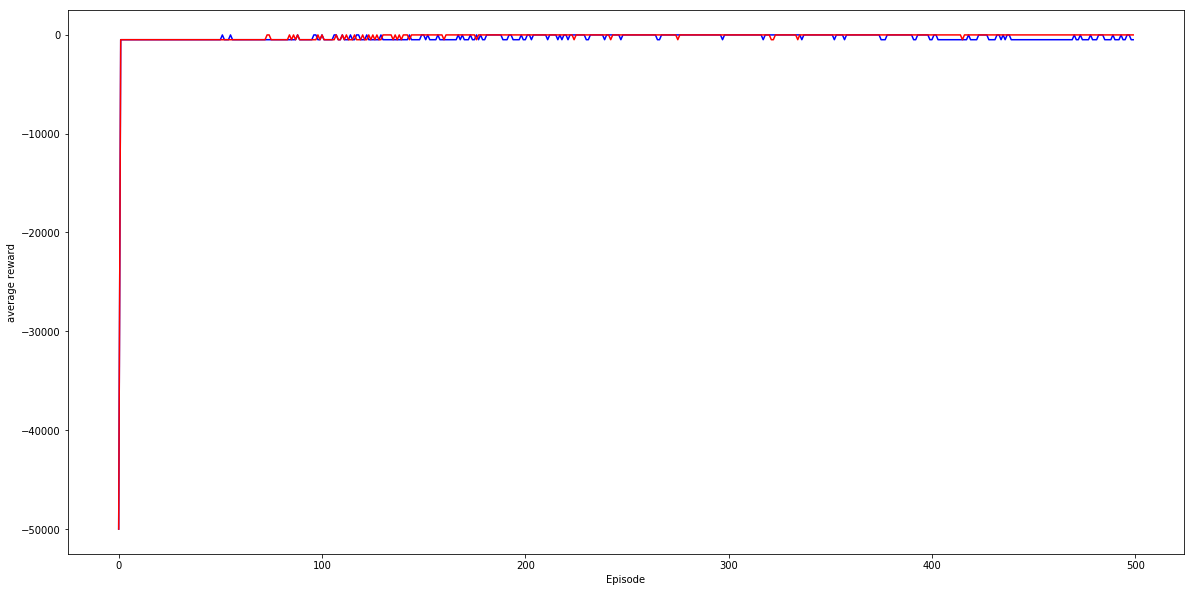

In [17]:
env = gym.make('CliffWalking-v0')
env.reset()

Q1, sample_episodes, avg_rewards_q1 = sarsa(env, 1.0, 500, epsilon=0.11, step_size= 0.2)
Q2, sample_episodes, avg_rewards_q2 = expected_sarsa(env, 1.0, 500, epsilon=0.11, step_size= 0.2)

env.close()

fig = plt.figure(figsize=(20,10))
plt.plot(sample_episodes, avg_rewards_q1, 'b')
plt.plot(sample_episodes, avg_rewards_q2, 'r')
plt.ylabel('average reward')
plt.xlabel('Episode')
plt.show()

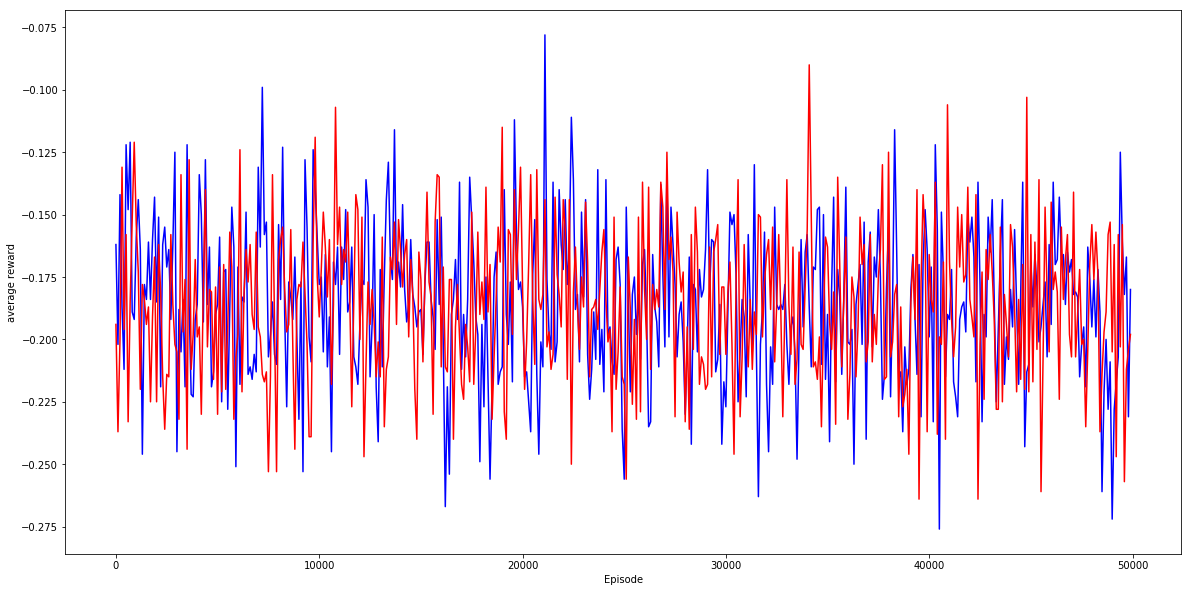

In [18]:
env = gym.make('Blackjack-v0')

Q1, sample_episodes, avg_rewards_q1 = sarsa(env, 0.9, 50000)
Q2, sample_episodes, avg_rewards_q2 = expected_sarsa(env, 0.9, 50000)

env.close()

fig = plt.figure(figsize=(20,10))
plt.plot(sample_episodes, avg_rewards_q1, 'b')
plt.plot(sample_episodes, avg_rewards_q2, 'r')
plt.ylabel('average reward')
plt.xlabel('Episode')
plt.show()

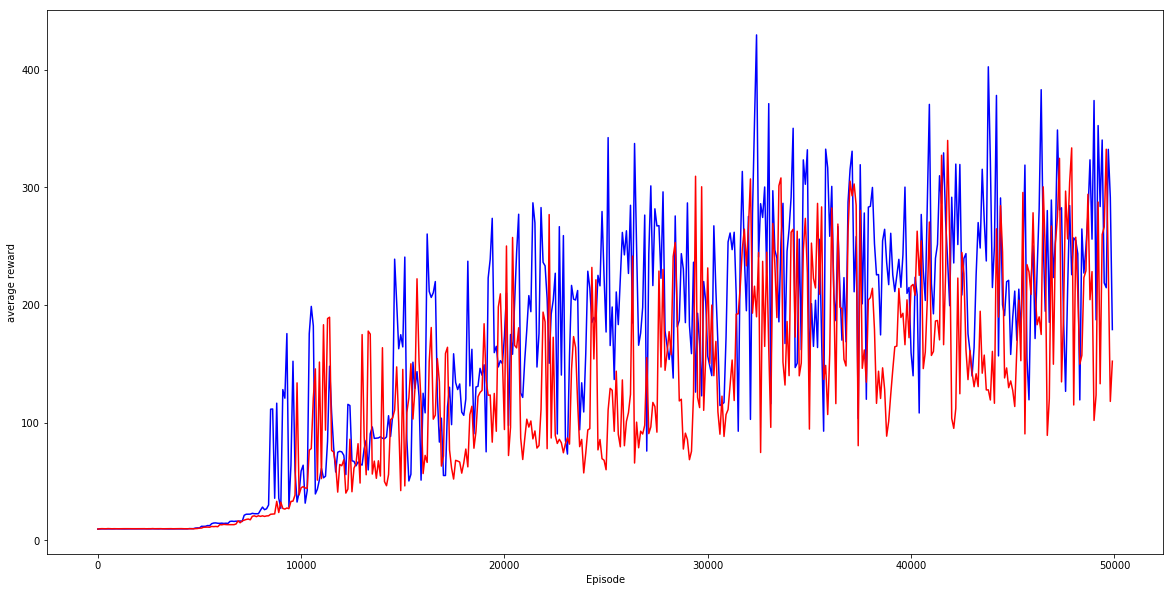

In [19]:
d_space = [np.linspace(-4.8, 4.8, 40),
           np.linspace(-2, 2, 40),
           np.linspace(-0.418,0.418, 48),
           np.linspace(-2, 2, 40)]

def d_cartpole_state_space(observation):
    return tuple(int(np.digitize(l, g)) for l, g in zip(observation, d_space))

env = gym.make('CartPole-v1')

Q1, sample_episodes, avg_rewards_q1 = sarsa(env, 1.0, 50000, state_space_fn=d_cartpole_state_space)
Q2, sample_episodes, avg_rewards_q2 = expected_sarsa(env, 1.0, 50000, state_space_fn=d_cartpole_state_space)

env.close()

fig = plt.figure(figsize=(20,10))
plt.plot(sample_episodes, avg_rewards_q1, 'b')
plt.plot(sample_episodes, avg_rewards_q2, 'r')
plt.ylabel('average reward')
plt.xlabel('Episode')
plt.show()